In [1]:
import os
import cv2
import numpy as np

def load_data():
  base_folder = 'iNaturalist'
  toxic_folder = f'{base_folder}/toxic_images'
  nontoxic_folder = f'{base_folder}/nontoxic_images'

  toxic_paths = [os.path.join(dp, f) for dp, dn, filenames  in os.walk(toxic_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg']
  nontoxic_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(nontoxic_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg']

  toxic_imgs = [cv2.imread(path) for path in toxic_paths]
  nontoxic_imgs = [cv2.imread(path) for path in nontoxic_paths]

  return toxic_imgs, nontoxic_imgs


data = load_data()


In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
toxic_imgs, nontoxic_imgs = data
IMG_SHAPE = (224, 224, 3)
prepared_toxic_imgs = np.array([cv2.resize(img, IMG_SHAPE[:2]) for img in toxic_imgs])
prepared_nontoxic_imgs = np.array([cv2.resize(img, IMG_SHAPE[:2]) for img in nontoxic_imgs])

In [4]:
toxic_labels = np.array([[1, 0] for _ in range(len(prepared_toxic_imgs))])
nontoxic_labels = np.array([[0, 1] for _ in range(len(prepared_nontoxic_imgs))])

X = np.vstack((prepared_toxic_imgs, prepared_nontoxic_imgs))
y = np.vstack((toxic_labels, nontoxic_labels))

X, y = shuffle(X, y, random_state=42)
y = np.argmax(y, axis=1)

# Split the data into temporary and testing (combined test/validation) sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.105, random_state=42)

# Split the temporary set into the actual test and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.12, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)


(2724, 224, 224, 3) (2724,) (364, 224, 224, 3) (364,) (372, 224, 224, 3) (372,)


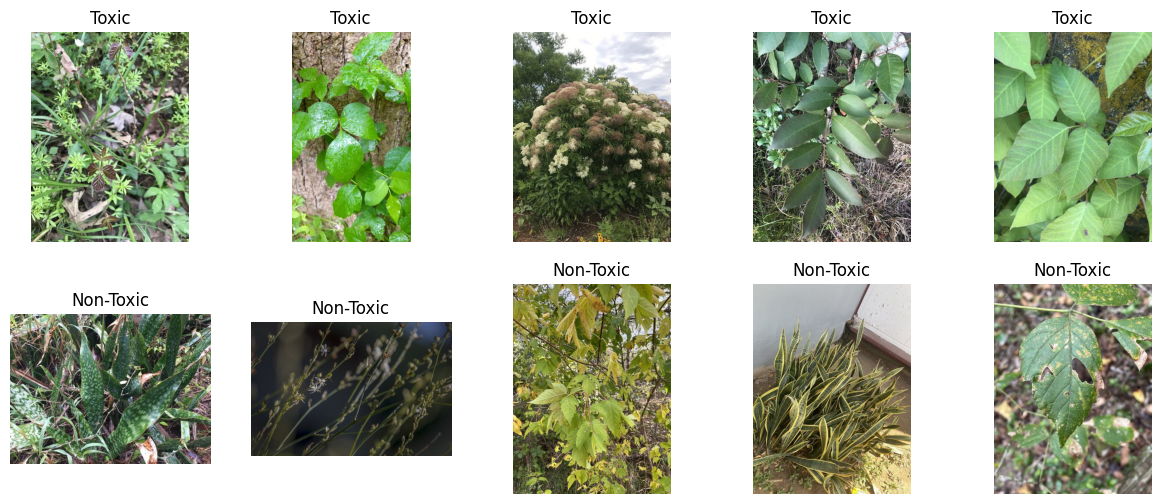

In [5]:
import random
import matplotlib.pyplot as plt

def display_random_images(toxic_imgs, nontoxic_imgs, num_toxic=5, num_nontoxic=5):
    random_toxic_imgs = random.sample(toxic_imgs, num_toxic)
    random_nontoxic_imgs = random.sample(nontoxic_imgs, num_nontoxic)

    plt.figure(figsize=(15, 6))

    for i, img in enumerate(random_toxic_imgs):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Toxic')
        plt.axis('off')

    for i, img in enumerate(random_nontoxic_imgs):
        plt.subplot(2, 5, num_toxic + i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Non-Toxic')
        plt.axis('off')

    plt.show()

# Use the function to display 5 toxic and 5 non-toxic images
display_random_images(toxic_imgs, nontoxic_imgs, num_toxic=5, num_nontoxic=5)


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

for layer in base_model.layers:
    layer.trainable = False

2023-12-09 17:30:46.244007: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-09 17:30:46.244032: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-09 17:30:46.244036: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-09 17:30:46.244067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-09 17:30:46.244081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
import platform

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

if platform.system() == "Darwin" and platform.processor() == "arm":
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
else:
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Callback to save weights of the best model based on validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1_virginia/',  
    save_weights_only=True,
    save_best_only=True,  
    monitor='val_accuracy',  
    mode='max',  
    verbose=1  
)

history_transfer_p1 = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/20


2023-12-09 17:30:49.442924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.6612

2023-12-09 17:30:57.403739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.73118, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1_virginia/
86/86 [==============================] - 11s 112ms/step - loss: 0.6726 - accuracy: 0.6612 - val_loss: 0.5380 - val_accuracy: 0.7312
Epoch 2/20
85/86 [============================>.] - ETA: 0s - loss: 0.5345 - accuracy: 0.7324
Epoch 2: val_accuracy improved from 0.73118 to 0.77151, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1_virginia/
86/86 [==============================] - 8s 95ms/step - loss: 0.5348 - accuracy: 0.7320 - val_loss: 0.5068 - val_accuracy: 0.7715
Epoch 3/20
85/86 [============================>.] - ETA: 0s - loss: 0.4650 - accuracy: 0.7761
Epoch 3: val_accuracy improved from 0.77151 to 0.77957, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1_virginia/
86/86 [==============================] - 8s 93ms/step - loss

In [9]:
eval_result = model.evaluate(X_test, y_test)
print(f"Test loss: {eval_result[0]}, Test accuracy: {eval_result[1]}")

12/12 [==============================] - 1s 124ms/step - loss: 0.4057 - accuracy: 0.8132
Test loss: 0.4057101607322693, Test accuracy: 0.8131868243217468


In [10]:
import pickle

# Save the history_c1 object to a file
with open('history_transfer_p1.pkl', 'wb') as file:
    pickle.dump(history_transfer_p1.history, file)

# Load the history_c1 object from a file
with open('history_transfer_p1.pkl', 'rb') as file:
    loaded_history_transfer_p1 = pickle.load(file)

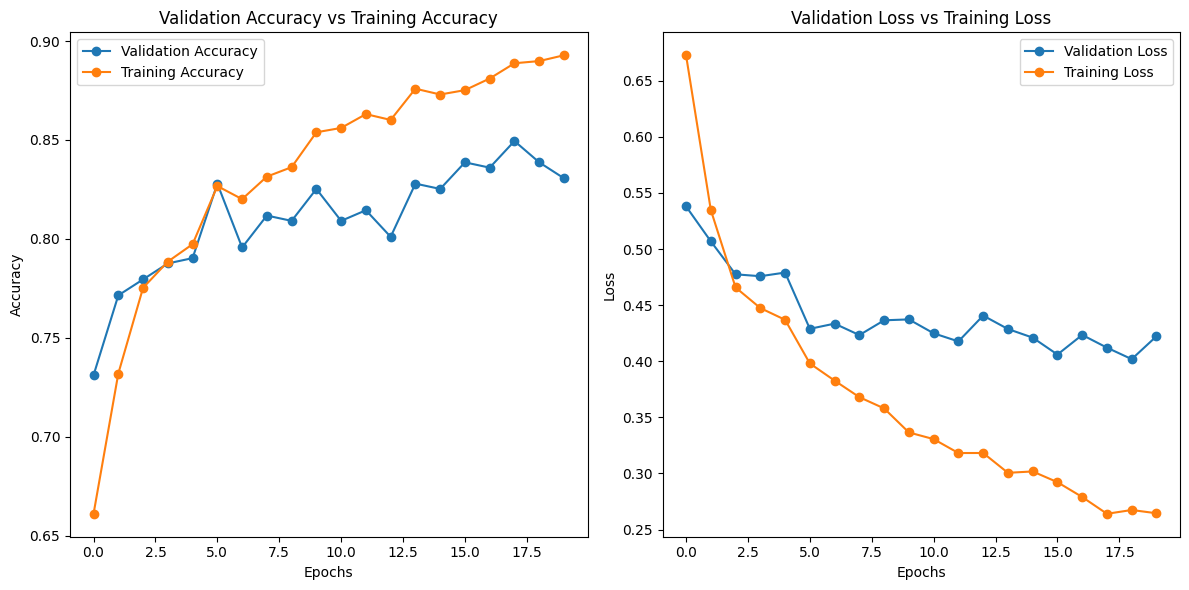

In [14]:
import matplotlib.pyplot as plt

history_c1_dict = loaded_history_transfer_p1

# Plotting validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_c1_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(history_c1_dict['accuracy'], label='Training Accuracy', marker='o')
plt.title('Validation Accuracy vs Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting validation loss
plt.subplot(1, 2, 2)
plt.plot(history_c1_dict['val_loss'], label='Validation Loss', marker='o')
plt.plot(history_c1_dict['loss'], label='Training Loss', marker='o')
plt.title('Validation Loss vs Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


# Phase 2
Unfreeze ResNet50 layers and train the whole model with a very low learning rate

In [17]:
# Unfreeze the top N layers of the base model
N = 15
for layer in model.layers[0].layers[-N:]:
    layer.trainable = True


if platform.system() == "Darwin" and platform.processor() == "arm":
    opt_2 = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
else:
    opt_2 = tf.keras.optimizers.Adam(learning_rate=0.00001)


# Compile the model with a lower learning rate
model.compile(optimizer=opt_2, loss='binary_crossentropy', metrics=['accuracy'])

# Callback to save weights of the best model 
checkpoint_callback_finetune = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p2_virginia/',  
    save_weights_only=True,
    save_best_only=True,  
    monitor='val_accuracy',  
    mode='max',  
    verbose=1  
)

# Fine-tune the model
history_transfer_p2 = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint_callback_finetune])

Epoch 1/10


2023-12-09 17:37:23.825166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8664

2023-12-09 17:37:32.835697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.80914, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p2_virginia/
86/86 [==============================] - 12s 124ms/step - loss: 0.2944 - accuracy: 0.8664 - val_loss: 0.4586 - val_accuracy: 0.8091
Epoch 2/10
86/86 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9093
Epoch 2: val_accuracy improved from 0.80914 to 0.82527, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p2_virginia/
86/86 [==============================] - 9s 106ms/step - loss: 0.2253 - accuracy: 0.9093 - val_loss: 0.4420 - val_accuracy: 0.8253
Epoch 3/10
86/86 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9332
Epoch 3: val_accuracy improved from 0.82527 to 0.83065, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p2_virginia/
86/86 [==============================] - 9s 104ms/step - lo

In [12]:
model.load_weights('/Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p2_virginia/')

In [18]:
eval_result = model.evaluate(X_test, y_test)
print(f"Test loss: {eval_result[0]}, Test accuracy: {eval_result[1]}")

12/12 [==============================] - 1s 120ms/step - loss: 0.4369 - accuracy: 0.8187
Test loss: 0.4369088113307953, Test accuracy: 0.8186812996864319


In [19]:
import pickle

# Save the history_c1 object to a file
with open('history_transfer_p2.pkl', 'wb') as file:
    pickle.dump(history_transfer_p2.history, file)

# Load the history_c1 object from a file
with open('history_transfer_p2.pkl', 'rb') as file:
    loaded_history_transfer_p2 = pickle.load(file)

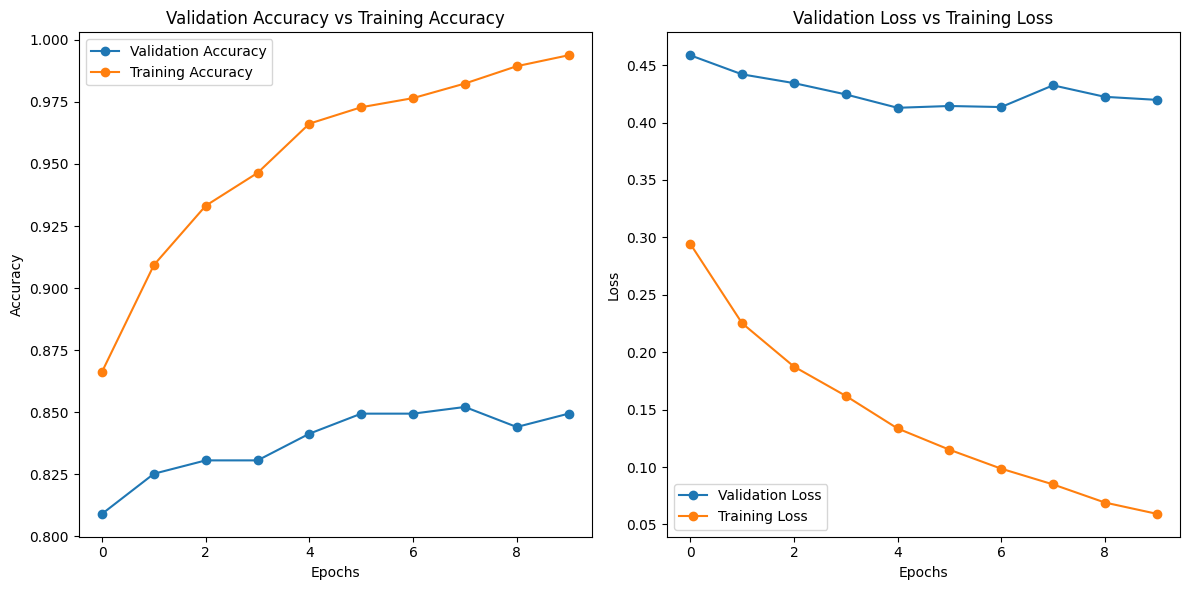

In [20]:
import matplotlib.pyplot as plt

history_c1_dict = loaded_history_transfer_p2

# Plotting validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_c1_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(history_c1_dict['accuracy'], label='Training Accuracy', marker='o')
plt.title('Validation Accuracy vs Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting validation loss
plt.subplot(1, 2, 2)
plt.plot(history_c1_dict['val_loss'], label='Validation Loss', marker='o')
plt.plot(history_c1_dict['loss'], label='Training Loss', marker='o')
plt.title('Validation Loss vs Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

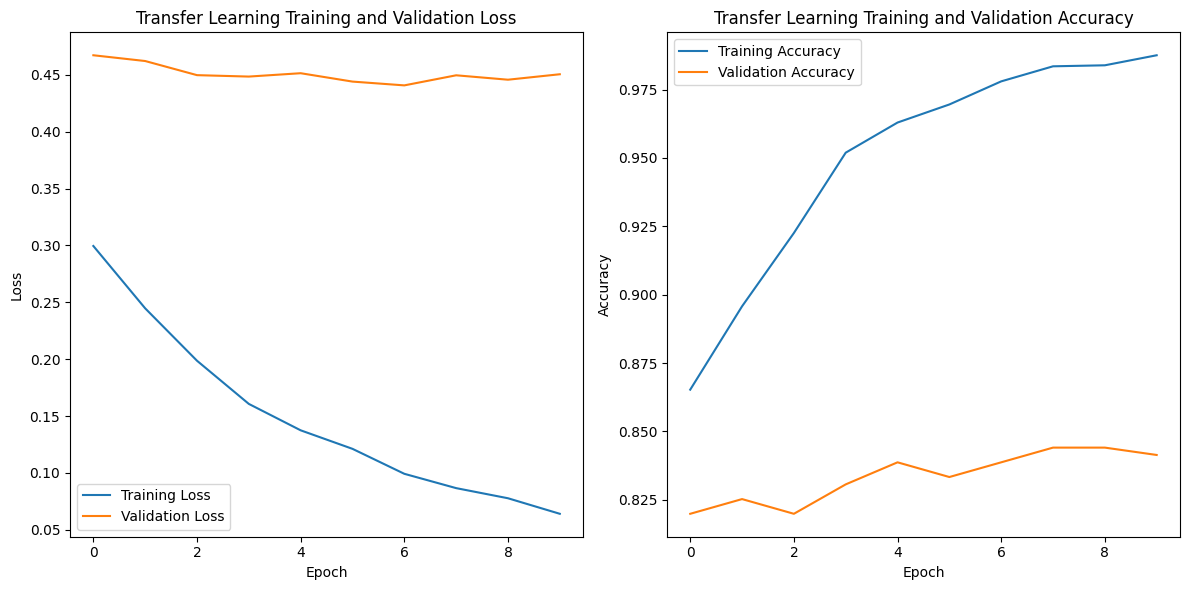

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_transfer_p2.history['loss'], label='Training Loss')
plt.plot(history_transfer_p2.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_transfer_p2.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer_p2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24112513 (91.98 MB)
Trainable params: 6045185 (23.06 MB)
Non-trainable params: 18067328 (68.92 MB)
_________